In [1]:
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
import seaborn as sns
import env

# Exercises
- file name: `time_series_anomaly_detection.py` or `time_series_anomaly_detection.ipynb`

The dataset for these exercises lives in the Codeup Data Science MySQL Server. The database name is curriculum_logs.

**Hint**: You will need to explore the database and significantly adjust your acquisition step (yay SQL!)

1. Label students by the program they are in.
1. Is it possible to identify the user_id of a staff member?
1. Identify students who are accessing our curriculum pages beyond the end of their time at Codeup.
1. Identify students who present anomalous activity using the Bollinger Band method, but reduce K to 2. 
1. Plot the access activity of these students.

**BONUS:** Identify users who are viewing both the web dev and data science curriculum

In [2]:
url = f'mysql+pymysql://{env.user}:{env.password}@{env.host}/curriculum_logs'
query = '''
SELECT date, 
path as endpoint, 
user_id, 
cohort_id, 
ip as source_ip, 
name as cohort_name, 
program_id,
start_date,
end_date
FROM curriculum_logs.logs as l
JOIN curriculum_logs.cohorts as c ON c.id = l.cohort_id;
'''
df = pd.read_sql(query, url)
df.head()

,date,endpoint,user_id,cohort_id,source_ip,cohort_name,program_id,start_date,end_date
0,2018-01-26,/,1,8.0,97.105.19.61,Hampton,1,2015-09-22,2016-02-06
1,2018-01-26,java-ii,1,8.0,97.105.19.61,Hampton,1,2015-09-22,2016-02-06
2,2018-01-26,java-ii/object-oriented-programming,1,8.0,97.105.19.61,Hampton,1,2015-09-22,2016-02-06
3,2018-01-26,slides/object_oriented_programming,1,8.0,97.105.19.61,Hampton,1,2015-09-22,2016-02-06
4,2018-01-26,javascript-i/conditionals,2,22.0,97.105.19.61,Teddy,2,2018-01-08,2018-05-17


In [3]:
df.shape

(847330, 9)

In [4]:
df.to_csv('log_df')
# df = pd.read_csv('log_df')

In [5]:
df.date = pd.to_datetime(df.date)
df = df.set_index(df.date)

In [6]:
df.program_id.value_counts()

2    713365
3    103412
1     30548
4         5
Name: program_id, dtype: int64

### Label students by the program they are in.

In [7]:
df['id_and_cohort'] = df.user_id.astype(str) + '_' + df.cohort_name
df.head()

,date,endpoint,user_id,cohort_id,source_ip,cohort_name,program_id,start_date,end_date,id_and_cohort
date,,,,,,,,,,
2018-01-26,2018-01-26,/,1,8.0,97.105.19.61,Hampton,1,2015-09-22,2016-02-06,1_Hampton
2018-01-26,2018-01-26,java-ii,1,8.0,97.105.19.61,Hampton,1,2015-09-22,2016-02-06,1_Hampton
2018-01-26,2018-01-26,java-ii/object-oriented-programming,1,8.0,97.105.19.61,Hampton,1,2015-09-22,2016-02-06,1_Hampton
2018-01-26,2018-01-26,slides/object_oriented_programming,1,8.0,97.105.19.61,Hampton,1,2015-09-22,2016-02-06,1_Hampton
2018-01-26,2018-01-26,javascript-i/conditionals,2,22.0,97.105.19.61,Teddy,2,2018-01-08,2018-05-17,2_Teddy


In [8]:
df.groupby(['program_id', 'cohort_name']).sum()

user_id  cohort_id
program_id cohort_name                     
1          Arches         745621     8890.0
           Badlands        25412      186.0
           Denali            340       16.0
           Everglades        649        5.0
           Franklin        21962      432.0
           Glacier         77244     4186.0
           Hampton         35867    13696.0
           Ike             67719     2783.0
           Joshua          54305     3624.0
           Kings          221079    36985.0
           Lassen         639423   134218.0
           Olympic       1490688    84218.0
           Quincy         171730    23503.0
2          Andromeda     9893305   786129.0
           Apex         20433773  1879808.0
           Bash         12839780  1080493.0
           Betelgeuse   12366627   939392.0
           Ceres        18196972  1344090.0
           Deimos       16435533  1677288.0
           Europa       14816619  1457716.0
           Fortuna      19853599  1955806.0
           Ganymede     21514819  1929108.0
           Hyperion     19866593  1731590.0
           Jupiter      28296551  2300758.0
           Kalypso      18657118  3127212.0
           Luna         13719261  2227482.0
           Mammoth         76565    10365.0
           Marco        14370028  2213595.0
           Neptune       6781883  1004088.0
           Niagara         55053    12080.0
           Oberon        1616236   232408.0
           Pinnacles      288508    38844.0
           Sequoia        449673   156324.0
           Staff        21734659  2352868.0
           Teddy         1279609   680372.0
           Ulysses       3770950   656282.0
           Voyageurs     6991743   855264.0
           Wrangell      5960791   639650.0
           Xanadu        7576473   721474.0
           Yosemite      6240730   560061.0
           Zion         12767203  1104784.0
3          Bayes        12528415   902292.0
           Curie        12640556  1187010.0
           Darden       21820199  1888885.0
           Easley       11831877  1957095.0
           Florence      7757334  1172994.0
4          Apollo            760       45.0

### Is it possible to identify the user_id of a staff member?

In [9]:
df['is_staff'] = df.cohort_name == 'Staff'
df.head()

,date,endpoint,user_id,cohort_id,source_ip,cohort_name,program_id,start_date,end_date,id_and_cohort,is_staff
date,,,,,,,,,,,
2018-01-26,2018-01-26,/,1,8.0,97.105.19.61,Hampton,1,2015-09-22,2016-02-06,1_Hampton,False
2018-01-26,2018-01-26,java-ii,1,8.0,97.105.19.61,Hampton,1,2015-09-22,2016-02-06,1_Hampton,False
2018-01-26,2018-01-26,java-ii/object-oriented-programming,1,8.0,97.105.19.61,Hampton,1,2015-09-22,2016-02-06,1_Hampton,False
2018-01-26,2018-01-26,slides/object_oriented_programming,1,8.0,97.105.19.61,Hampton,1,2015-09-22,2016-02-06,1_Hampton,False
2018-01-26,2018-01-26,javascript-i/conditionals,2,22.0,97.105.19.61,Teddy,2,2018-01-08,2018-05-17,2_Teddy,False


In [15]:
df[df.is_staff == True].id_and_cohort.value_counts()

11_Staff     15178
64_Staff     12530
428_Staff     5819
1_Staff       5787
248_Staff     5027
314_Staff     4617
53_Staff      4132
545_Staff     3528
211_Staff     3162
581_Staff     2961
546_Staff     2585
514_Staff     2073
315_Staff     2042
404_Staff     1668
816_Staff     1527
742_Staff     1507
480_Staff     1256
146_Staff     1216
521_Staff     1088
430_Staff      981
744_Staff      651
951_Staff      583
893_Staff      402
572_Staff      390
37_Staff       374
502_Staff      357
618_Staff      318
397_Staff      305
630_Staff      253
41_Staff       204
257_Staff      160
308_Staff      151
513_Staff      132
312_Staff      131
854_Staff      131
738_Staff      128
653_Staff      117
953_Staff       85
539_Staff       84
40_Staff        66
620_Staff       58
370_Staff       54
813_Staff       49
855_Staff       47
745_Staff       46
894_Staff       29
148_Staff       26
461_Staff       11
980_Staff        3
652_Staff        1
592_Staff        1
Name: id_and_cohort, dtype: int

#### I think the df is looking good up to this point

### Identify students who are accessing our curriculum pages beyond the end of their time at Codeup.

In [16]:
df.head(1)

,date,endpoint,user_id,cohort_id,source_ip,cohort_name,program_id,start_date,end_date,id_and_cohort,is_staff
date,,,,,,,,,,,
2018-01-26,2018-01-26,/,1,8.0,97.105.19.61,Hampton,1,2015-09-22,2016-02-06,1_Hampton,False


In [17]:
df[df.is_staff == False & (df.date > df.end_date)].id_and_cohort.value_counts()

53_Lassen         8197
495_Deimos        6451
344_Zion          5460
570_Fortuna       4584
423_Betelgeuse    3804
                  ... 
918_Neptune          1
593_Lassen           1
212_Arches           1
649_Everglades       1
66_Kings             1
Name: id_and_cohort, Length: 901, dtype: int64

### Identify students who present anomalous activity using the Bollinger Band method, but reduce K to 2.

In [18]:
df.head(1)

,date,endpoint,user_id,cohort_id,source_ip,cohort_name,program_id,start_date,end_date,id_and_cohort,is_staff
date,,,,,,,,,,,
2018-01-26,2018-01-26,/,1,8.0,97.105.19.61,Hampton,1,2015-09-22,2016-02-06,1_Hampton,False


<AxesSubplot:xlabel='date'>

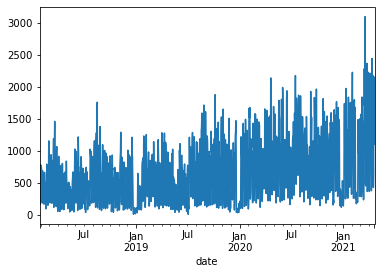

In [19]:
pages = df['endpoint'].resample('d').count()
pages.plot()

In [20]:
# 7 day EMA
ema_7d = pages.ewm(span=7).mean()
ema_14d = pages.ewm(span=14).mean()
ema_30d = pages.ewm(span=30).mean()
ema_90d = pages.ewm(span=90).mean()

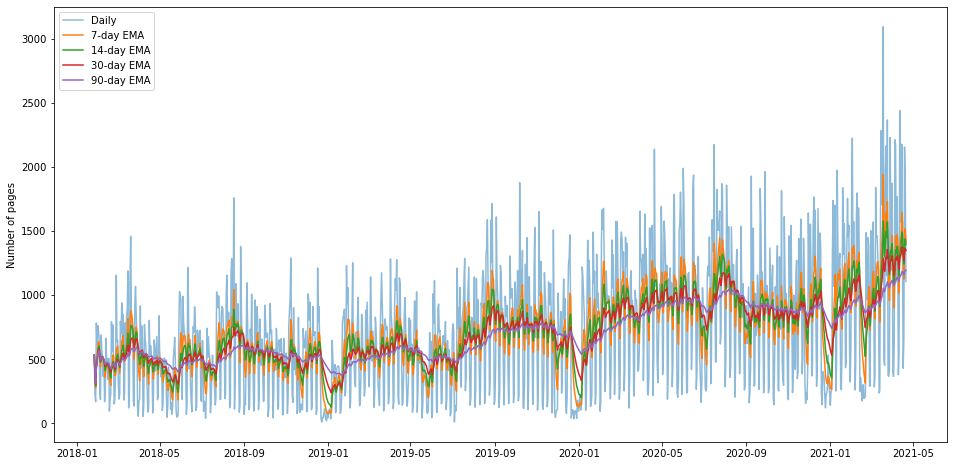

In [21]:
fig, ax = plt.subplots(figsize=(16,8))

ax.plot(pages.index, pages, label='Daily', alpha=.5)

ax.plot(pages.index, ema_7d, label = '7-day EMA')
ax.plot(pages.index, ema_14d, label = '14-day EMA')
ax.plot(pages.index, ema_30d, label = '30-day EMA')
ax.plot(pages.index, ema_90d, label = '90-day EMA')

ax.legend(loc='best')
ax.set_ylabel('Number of pages')

plt.show()

In [22]:
# set the window span
span = 30

# compute midband
midband = pages.ewm(span=span).mean()
midband.head()

date
2018-01-26    533.000000
2018-01-27    376.450000
2018-01-28    302.284709
2018-01-29    434.739290
2018-01-30    475.525441
Freq: D, Name: endpoint, dtype: float64

In [23]:
stdev = pages.ewm(span=span).std()
# stdev.head()

In [24]:
# compute upper and lower bands
ub = midband + stdev*2
lb = midband - stdev*2
# ub, lb

In [25]:
bb = pd.concat([ub, lb], axis=1)

bb.columns = ['ub', 'lb']
# bb.head()

In [26]:
my_df = pd.concat([pages, midband, bb], axis=1)
my_df.columns = ['pages', 'midband', 'ub', 'lb']
my_df.head()

,pages,midband,ub,lb
date,,,,
2018-01-26,533,533.000000,NaN,NaN
2018-01-27,230,376.450000,804.956709,-52.056709
2018-01-28,168,302.284709,687.762221,-83.192803
2018-01-29,783,434.739290,1019.718202,-150.239623
2018-01-30,614,475.525441,1001.085795,-50.034912


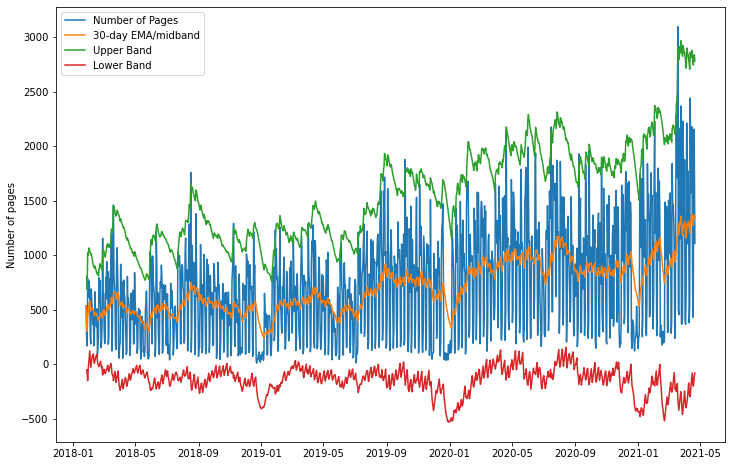

In [27]:
fig, ax = plt.subplots(figsize=(12,8))

ax.plot(my_df.index, my_df.pages, label='Number of Pages')

ax.plot(my_df.index, my_df.midband, label = '30-day EMA/midband')
ax.plot(my_df.index, my_df.ub, label = 'Upper Band')
ax.plot(my_df.index, my_df.lb, label = 'Lower Band')

ax.legend(loc='best')
ax.set_ylabel('Number of pages')

plt.show()

In [28]:
# get the value of the last record
last_measure = my_df.iloc[-1].pages
# get the lower band value on the last date
last_lb = my_df.iloc[-1].lb
# get the upper band value on the last date
last_ub = my_df.iloc[-1].ub
# compute %b
last_pct_b = (last_measure - last_lb)/(last_ub - last_lb)

In [29]:
my_df['pct_b'] = (my_df['pages'] - my_df['lb'])/(my_df['ub'] - my_df['lb'])

my_df.head()

,pages,midband,ub,lb,pct_b
date,,,,,
2018-01-26,533,533.000000,NaN,NaN,NaN
2018-01-27,230,376.450000,804.956709,-52.056709,0.329116
2018-01-28,168,302.284709,687.762221,-83.192803,0.325820
2018-01-29,783,434.739290,1019.718202,-150.239623,0.797669
2018-01-30,614,475.525441,1001.085795,-50.034912,0.631740


In [30]:
my_df[my_df['pct_b']>1]

,pages,midband,ub,lb,pct_b
date,,,,,
2018-02-27,1156,475.918187,1051.308691,-99.472317,1.090974
2018-03-20,1460,649.891473,1451.666606,-151.883660,1.005197
2018-05-30,1028,375.089886,971.090171,-220.910400,1.047743
2018-07-23,1026,426.685621,997.344326,-143.973083,1.025108
2018-08-17,1760,748.528472,1654.637043,-157.580099,1.058140
2018-11-08,1291,559.032878,1248.528536,-130.462781,1.030799
2019-01-28,1232,446.166837,1165.703309,-273.369635,1.046069
2019-07-08,1212,451.405230,1163.336355,-260.525895,1.034177
2019-10-07,1878,795.149179,1784.161043,-193.862685,1.047441


In [70]:
def acquire_logs(user=env.user, password=env.password, host=env.host):
    '''
    This function queries the Codeup MySQL curriculum_logs database and returns a dataframe
    '''
    url = f'mysql+pymysql://{env.user}:{env.password}@{env.host}/curriculum_logs'
    query = '''
    SELECT date,
           path as endpoint,
           user_id,
           cohort_id,
           ip as source_ip
    FROM logs;
    '''
    df = pd.read_sql(query, url)
    return df

def one_user_df_prep(df, user):
    '''
    This function returns a dataframe consisting of data for only a single defined user
    '''
    df = df[df.user_id == user]
#     df.date = pd.to_datetime(df.date)
#     df = df.set_index(df.date)
    pages_one_user = df['endpoint'].resample('d').count()
    return pages_one_user

def compute_pct_b(pages_one_user, span, weight, user):
    '''
    This function adds the %b of a bollinger band range for the page views of a single user's log activity
    '''
    # Calculate upper and lower bollinger band
    midband = pages_one_user.ewm(span=span).mean()
    stdev = pages_one_user.ewm(span=span).std()
    ub = midband + stdev*weight
    lb = midband - stdev*weight
    
    # Add upper and lower band values to dataframe
    bb = pd.concat([ub, lb], axis=1)
    
    # Combine all data into a single dataframe
    my_df = pd.concat([pages_one_user, midband, bb], axis=1)
    my_df.columns = ['pages_one_user', 'midband', 'ub', 'lb']
    
    # Calculate percent b and relevant user id to dataframe
    my_df['pct_b'] = (my_df['pages_one_user'] - my_df['lb'])/(my_df['ub'] - my_df['lb'])
    my_df['user_id'] = user
    return my_df

def plot_bands(my_df, user):
    '''
    This function plots the bolliger bands of the page views for a single user
    '''
    fig, ax = plt.subplots(figsize=(12,8))
    ax.plot(my_df.index, my_df.pages_one_user, label='Number of Pages, User: '+str(user))
    ax.plot(my_df.index, my_df.midband, label = 'EMA/midband')
    ax.plot(my_df.index, my_df.ub, label = 'Upper Band')
    ax.plot(my_df.index, my_df.lb, label = 'Lower Band')
    ax.legend(loc='best')
    ax.set_ylabel('Number of Pages')
    plt.show()

def find_anomalies(df, user, span, weight, plot=False):
    '''
    This function returns the records where a user's daily activity exceeded the upper limit of a bollinger band range
    '''
    
    # Reduce dataframe to represent a single user
    pages_one_user = one_user_df_prep(df, user)
    
    # Add bollinger band data to dataframe
    my_df = compute_pct_b(pages_one_user, span, weight, user)
    
    # Plot data if requested (plot=True)
    if plot:
        plot_bands(my_df, user)
    
    # Return only records that sit outside of bollinger band upper limit
    return my_df[my_df.pct_b>1]

In [71]:
span = 30
weight = 2

anomalies = pd.DataFrame()
for u in list(df.user_id.unique()):
    user_df = find_anomalies(df, u, span, weight)
    anomalies = pd.concat([anomalies, user_df], axis=0)

In [72]:
anomalies

,pages_one_user,midband,ub,lb,pct_b,user_id
date,,,,,,
2018-02-20,54,6.456745,35.718248,-22.804758,1.312386,1
2018-03-19,35,9.304089,32.368632,-13.760453,1.057044,1
2018-05-04,27,7.179313,24.736171,-10.377545,1.064471,1
2018-05-11,27,8.141119,26.687629,-10.405390,1.008421,1
2018-05-29,68,9.612443,44.787234,-25.562347,1.329963,1
...,...,...,...,...,...,...
2021-03-29,28,6.004114,24.426496,-12.418268,1.096988,948
2021-04-17,25,8.260254,23.336345,-6.815837,1.055175,948
2021-04-18,50,11.264267,37.649246,-15.120712,1.234049,948


In [73]:
anomalies.sort_values(by='pct_b', ascending=False)

,pages_one_user,midband,ub,lb,pct_b,user_id
date,,,,,,
2021-02-28,8,0.516129,4.514047,-3.481789,1.435971,459
2020-06-23,59,3.806452,33.291099,-25.678196,1.435971,134
2021-03-28,15,0.967742,8.463839,-6.528355,1.435971,13
2021-02-20,19,1.225806,10.720862,-8.269249,1.435971,266
2020-12-16,12,0.774194,6.771071,-5.222684,1.435971,156
...,...,...,...,...,...,...
2018-11-12,16,5.696792,15.996388,-4.602803,1.000175,271
2020-07-23,19,5.781676,18.995809,-7.432458,1.000159,625
2020-10-13,30,8.716060,29.996078,-12.563959,1.000092,757


In [74]:
anomalies.groupby(by='date').sum()

,pages_one_user,midband,ub,lb,pct_b,user_id
date,,,,,,
2018-02-05,119,26.690070,105.188240,-51.808099,3.276631,71
2018-02-06,134,42.499478,123.221228,-38.222272,4.329686,98
2018-02-07,61,9.959133,52.929543,-33.011277,3.247191,172
2018-02-08,17,3.952541,14.689157,-6.784075,2.221314,76
2018-02-09,27,8.627966,25.338353,-8.082420,1.049719,12
...,...,...,...,...,...,...
2021-04-17,29,8.731859,26.191383,-8.727665,2.295367,1528
2021-04-18,113,22.982939,92.925114,-46.959237,6.050798,3818
2021-04-19,499,111.776256,416.620444,-193.067932,14.812487,9572


In [75]:
anomalies.sort_values(by='pages_one_user', ascending=False)

,pages_one_user,midband,ub,lb,pct_b,user_id
date,,,,,,
2020-07-22,285,44.915959,192.499064,-102.667146,1.313386,11
2019-03-03,272,24.721632,163.040772,-113.597508,1.393869,341
2020-04-16,271,44.194413,193.288101,-104.899276,1.260614,570
2019-07-25,253,34.698961,160.039466,-90.641543,1.370832,422
2020-04-26,234,54.999406,211.467475,-101.468663,1.072004,570
...,...,...,...,...,...,...
2019-01-15,1,0.096889,0.790202,-0.596425,1.151301,50
2019-03-19,1,0.066996,0.668360,-0.534368,1.275740,219
2019-01-19,1,0.138718,0.903715,-0.626278,1.062932,50


<AxesSubplot:xlabel='date'>

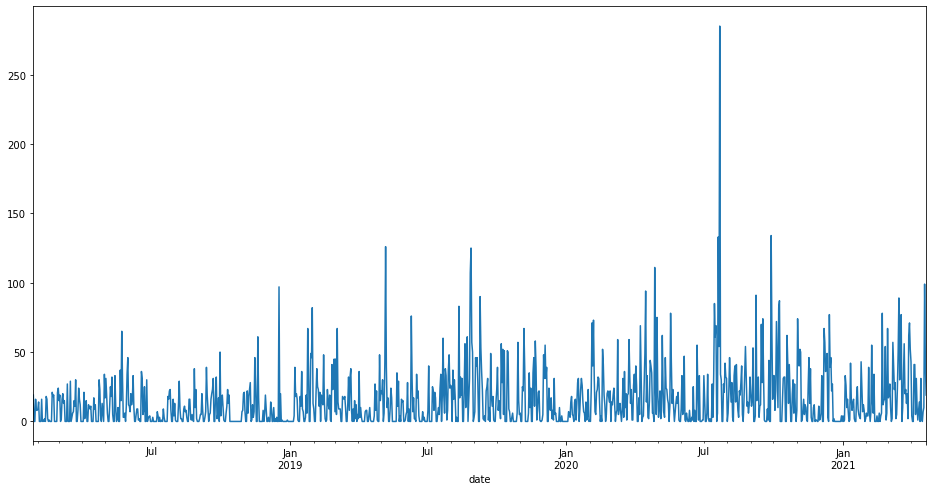

In [76]:
df_11 = one_user_df_prep(df, 11)
df_11.plot(figsize=(16,8))

- I think user 11 might be staff

In [77]:
df[df.user_id == 11].is_staff.value_counts()

True     15178
False     2735
Name: is_staff, dtype: int64

- oops, user 11 is staff and not staff--better redefine the columns in the anomalies dataframe to include id_and_cohort.
- on seconde thought, leaving this alone--this is obviously a graduate who was later hired.  

### Plot the access activity of these students

<AxesSubplot:xlabel='date'>

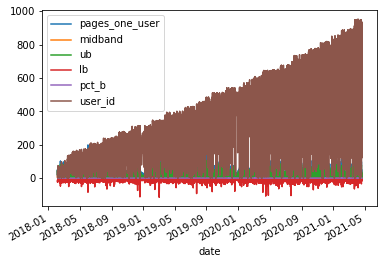

In [38]:
anomalies.sort_values(by='pages_one_user', ascending=False).plot()

In [42]:
anomalies.head()

,pages_one_user,midband,ub,lb,pct_b,user_id
date,,,,,,
2018-02-20,54,6.456745,35.718248,-22.804758,1.312386,1
2018-03-19,35,9.304089,32.368632,-13.760453,1.057044,1
2018-05-04,27,7.179313,24.736171,-10.377545,1.064471,1
2018-05-11,27,8.141119,26.687629,-10.405390,1.008421,1
2018-05-29,68,9.612443,44.787234,-25.562347,1.329963,1


<AxesSubplot:xlabel='user_id'>

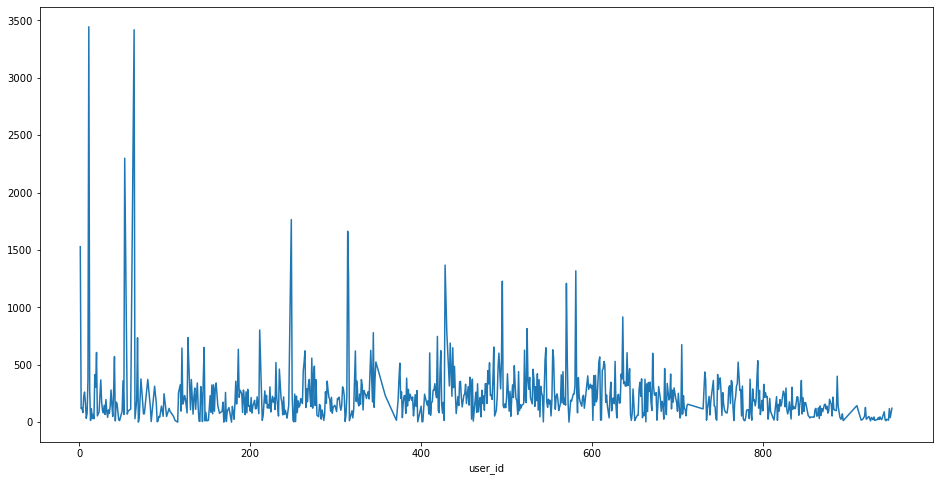

In [49]:
plt.figure(figsize=(16,8))
anomalies.groupby(by='user_id').pages_one_user.sum().plot()

In [54]:
anomalies.groupby(by='user_id').user_id.value_counts()

user_id  user_id
1        1          46
2        2           2
3        3           5
4        4           2
5        5           4
                    ..
945      945         2
947      947         1
948      948         4
949      949         1
951      951         1
Name: user_id, Length: 767, dtype: int64